In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
import time
import json
from tqdm import tqdm
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from torchvision.models.resnet import ResNet50_Weights
from sklearn.model_selection import train_test_split

In [2]:
# Params
training_date = time.strftime("%Y%m%d-%H%M%S")
BACTH_SIZE = 64
MODEL_NAME = f'MDM_IaA_01_dataset_fully_supervised_{training_date}'
DATASET_FILE_PATH = 'C:/Users/janny/Aalto_project_2/data/full_dataset_IaA.txt'
MODEL_DIR = os.path.join("C:/Users/janny/Aalto_project_2/models", MODEL_NAME)
SEED = 42

In [3]:
os.makedirs(MODEL_DIR, exist_ok=True)
destination_dir = os.path.join(MODEL_DIR, 'data')
os.makedirs(destination_dir, exist_ok=True)
destination_file_path = os.path.join(destination_dir, os.path.basename(DATASET_FILE_PATH))
shutil.copy(DATASET_FILE_PATH, destination_file_path)
DATASET_FILE_PATH = destination_file_path

all_data = pd.read_csv(DATASET_FILE_PATH, sep=', ', header=None)
class_counts = all_data.iloc[:, 12].value_counts()
print(class_counts)
sampled_data = pd.DataFrame()
for label, count in class_counts.items():
    # Sample 10% of the data for the current class
    sampled_df = all_data[all_data.iloc[:, 12] == label].sample(frac=0.1, random_state=SEED)
    sampled_data = pd.concat([sampled_data, sampled_df])

SAMPLED_DATASET_FILE_PATH = os.path.join(MODEL_DIR, 'data', 'dataset_01.csv')
sampled_data.to_csv(SAMPLED_DATASET_FILE_PATH, index=False, header=None)

DATASET_FILE_PATH = SAMPLED_DATASET_FILE_PATH

C:\Users\janny\AppData\Local\Temp\ipykernel_23832\365994654.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  all_data = pd.read_csv(DATASET_FILE_PATH, sep=', ', header=None)


12
0    13281
1     7821
Name: count, dtype: int64


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
class CustomDataset(Dataset):
    def __init__(self, annotations, transform_image, transform_audio):
        self.annotations = annotations
        self.transform_image = transform_image
        self.transform_audio = transform_audio

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        img_paths = row.iloc[:5].values  # Paths to the image files.
        spectrogram_paths = row.iloc[5:12].values  # Paths to the audio spectrogram files.
        label = row.iloc[12]
        
        # Load images and spectrograms, apply their transforms
        images = [self.transform_image(read_image(path)) for path in img_paths]
        spectrograms = [self.transform_audio(read_image(path)) for path in spectrogram_paths]

        return images, spectrograms, label

In [6]:
class ResizeToWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, img_tensor):
        # Make sure it's a float for division to work properly in Python 2
        original_width = img_tensor.shape[2]
        original_height = img_tensor.shape[1]
        aspect_ratio = float(original_height) / float(original_width)
        target_height = int(self.target_width * aspect_ratio)

        # Resize the tensor
        img_tensor = F.resize(img_tensor, [target_height, self.target_width])
        return img_tensor
    
class Normalize3Channel:
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std

    def __call__(self, img_tensor):
        # Check if the image has 3 channels
        img_tensor = img_tensor.float() / 255.0
        if img_tensor.shape[0] == 3:
            img_tensor = F.normalize(img_tensor, mean=self.mean, std=self.std)
        return img_tensor


In [7]:
transform_image = transforms.Compose([
    ResizeToWidth(512),  # Resize width to 512 pixels while maintaining aspect ratio
    transforms.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
    ),
    Normalize3Channel(),
])

transform_audio = transforms.Compose([
    ResizeToWidth(512),  # Resize width to 512 pixels while maintaining aspect ratio
    Normalize3Channel()
])

all_data = pd.read_csv(DATASET_FILE_PATH, sep=',')
train_data, test_data = train_test_split(all_data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_data, transform_image, transform_audio)
val_dataset = CustomDataset(val_data, transform_audio, transform_audio)
test_dataset = CustomDataset(test_data, transform_audio, transform_audio)

# Create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=BACTH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BACTH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BACTH_SIZE, shuffle=False)

In [8]:
def visualize_tensor(tensor):
    # Assuming tensor shape is [1, 3, H, W], we select the first item in the batch
    # and convert it to a NumPy array after normalizing
    tensor = tensor[0]  # Select the first item in the batch
    # Convert from tensor to PIL Image to easily display it
    image = F.to_pil_image(tensor)
    plt.imshow(image)
    plt.axis('off')  # Hide axes ticks
    plt.show()

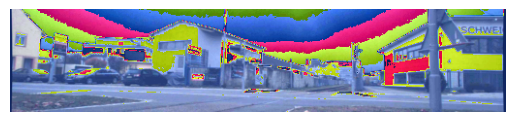

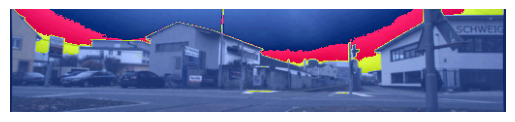

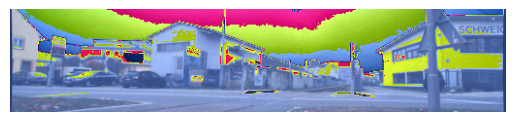

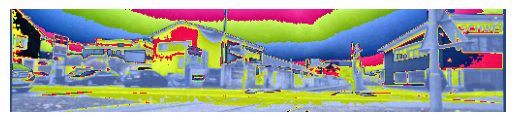

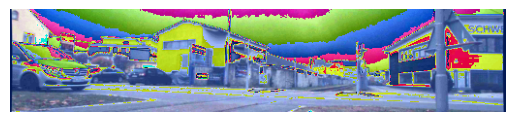

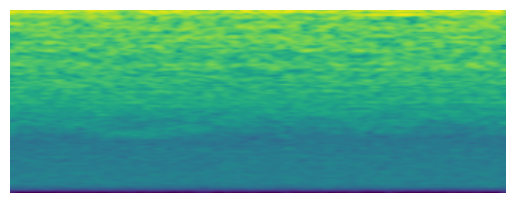

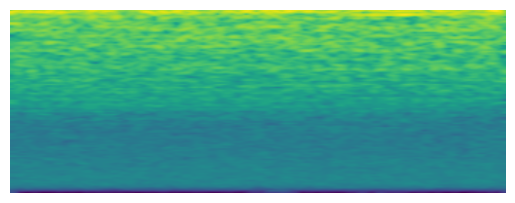

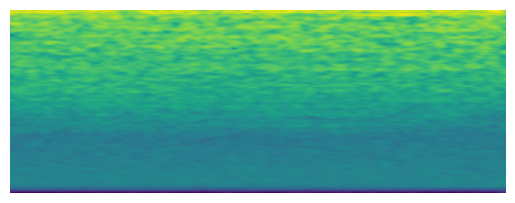

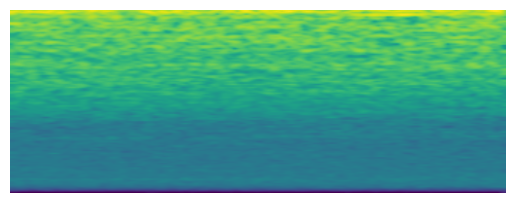

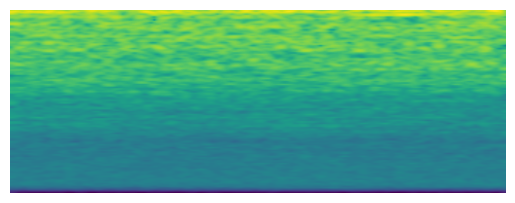

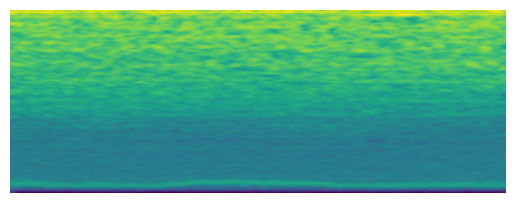

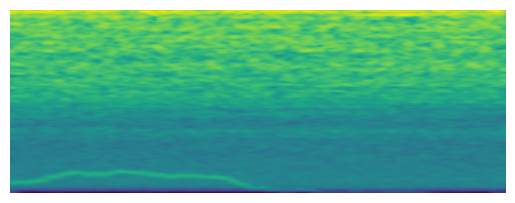

In [9]:
for images, spectrograms, labels in train_dataloader:
    # Your training loop here
    image_0 = images[0]
    image_1 = images[1]
    image_2 = images[2]
    image_3 = images[3]
    image_4 = images[4]

    spec_0 = spectrograms[0]
    spec_1 = spectrograms[1]
    spec_2 = spectrograms[2]
    spec_3 = spectrograms[3]
    spec_4 = spectrograms[4]
    spec_5 = spectrograms[5]
    spec_6 = spectrograms[6]

    visualize_tensor(image_0)
    visualize_tensor(image_1)
    visualize_tensor(image_2)
    visualize_tensor(image_3)
    visualize_tensor(image_4)

    visualize_tensor(spec_0)
    visualize_tensor(spec_1)
    visualize_tensor(spec_2)
    visualize_tensor(spec_3)
    visualize_tensor(spec_4)
    visualize_tensor(spec_5)
    visualize_tensor(spec_6)
    break

In [10]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, output_features):
        super(ImageFeatureExtractor, self).__init__()
        resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.features = nn.Sequential(*list(resnet50.children())[:-1])  # Remove the last layer

        # Freeze the parameters in the feature extraction layers
        for param in self.features.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(resnet50.fc.in_features, output_features)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
    
class AudioFeatureExtractor(nn.Module):
    def __init__(self, output_features):
        super(AudioFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 23 * 64, output_features)  # Adjust the size based on your input dimensions

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
    
class CombinedModel(nn.Module):
    def __init__(self, image_output_features, audio_output_features, num_classes):
        super(CombinedModel, self).__init__()
        self.image_extractor = ImageFeatureExtractor(image_output_features)
        self.audio_extractor = AudioFeatureExtractor(audio_output_features)

        # Combine features from both extractors
        total_features = image_output_features * 5 + audio_output_features * 7
        self.classifier = nn.Linear(total_features, num_classes)

    def forward(self, image_0, image_1, image_2, image_3, image_4,
        audio_0, audio_1, audio_2, audio_3, audio_4, audio_5, audio_6
    ):
        image_features_0 = self.image_extractor(image_0)
        image_features_1 = self.image_extractor(image_1)
        image_features_2 = self.image_extractor(image_2)
        image_features_3 = self.image_extractor(image_3)
        image_features_4 = self.image_extractor(image_4)

        audio_features_0 = self.audio_extractor(audio_0)
        audio_features_1 = self.audio_extractor(audio_1)
        audio_features_2 = self.audio_extractor(audio_2)
        audio_features_3 = self.audio_extractor(audio_3)
        audio_features_4 = self.audio_extractor(audio_4)
        audio_features_5 = self.audio_extractor(audio_5)
        audio_features_6 = self.audio_extractor(audio_6)
        
        combined_features = torch.cat((
            image_features_0, image_features_1, image_features_2, image_features_3, image_features_4,
            audio_features_0, audio_features_1, audio_features_2, audio_features_3, audio_features_4,
            audio_features_5, audio_features_6
        ), dim=1)
        output = self.classifier(combined_features)
        return output

In [11]:
image_output_features = 512 # Adjust as needed
audio_output_features = 256  # Adjust as needed
num_classes = 2  # Adjust based on your dataset

model = CombinedModel(image_output_features, audio_output_features, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted
criterion = nn.CrossEntropyLoss()

In [12]:
num_epochs = 20  # Number of epochs can be adjusted
train_metrics = []
val_metrics = []
best_score = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_running_loss = 0.0
    train_TP = 0
    train_FP = 0
    train_FN = 0
    train_TN = 0

    loop = tqdm(train_dataloader, leave=True)
    for i, (images, spectrograms, labels) in enumerate(loop):     
        # Zero the parameter gradients
        optimizer.zero_grad()

        image_0 = images[0].to(device)
        image_1 = images[1].to(device)
        image_2 = images[2].to(device)
        image_3 = images[3].to(device)
        image_4 = images[4].to(device)

        spec_0 = spectrograms[0].to(device)
        spec_1 = spectrograms[1].to(device)
        spec_2 = spectrograms[2].to(device)
        spec_3 = spectrograms[3].to(device)
        spec_4 = spectrograms[4].to(device)
        spec_5 = spectrograms[5].to(device)
        spec_6 = spectrograms[6].to(device)

        # Forward pass
        outputs = model(
            image_0, image_1, image_2, image_3, image_4,
            spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
        )

        # Convert labels and predictions to boolean values if they're not already
        labels_bool = labels.bool()
        outputs = outputs.cpu()
        _, predicted_classes = torch.max(outputs, 1)

        train_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
        train_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
        train_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
        train_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()

        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        train_running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            accuracy = (train_TP + train_TN) / (train_TP + train_FP + train_FN + train_TN)
            recall = train_TP / (train_TP + train_FN) if (train_TP + train_FN) > 0 else 0
            iou = train_TP / (train_TP + train_FP + train_FN) if (train_TP + train_FP + train_FN) > 0 else 0
            
            print(f"[Epoch: {epoch + 1}, Batch: {i + 1}] Loss: {train_running_loss / 10:.4f}, "
                  f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")
            
            metric = {
                "loss": train_running_loss / 10,
                "accuracy": accuracy,
                "recall": recall,
                "iou": iou,
                "TP": train_TP,
                "FP": train_FP,
                "TN": train_TN,
                "FN": train_FN,
            }

            train_metrics.append(metric)

            train_running_loss = 0.0
            train_TP = 0
            train_FP = 0
            train_FN = 0
            train_TN = 0

            with open(f'{MODEL_DIR}/training_metrics.json', 'w') as f:
                json.dump(train_metrics, f, indent=4)
    
    with torch.no_grad():
        model.eval()  # Set the model to training mode
        val_loss = 0.0
        val_TP = 0
        val_FP = 0
        val_FN = 0
        val_TN = 0

        loop = tqdm(val_dataloader, leave=True)
        k = 0
        for i, (images, spectrograms, labels) in enumerate(loop):     
            image_0 = images[0].to(device)
            image_1 = images[1].to(device)
            image_2 = images[2].to(device)
            image_3 = images[3].to(device)
            image_4 = images[4].to(device)

            spec_0 = spectrograms[0].to(device)
            spec_1 = spectrograms[1].to(device)
            spec_2 = spectrograms[2].to(device)
            spec_3 = spectrograms[3].to(device)
            spec_4 = spectrograms[4].to(device)
            spec_5 = spectrograms[5].to(device)
            spec_6 = spectrograms[6].to(device)

            # Forward pass
            outputs = model(
                image_0, image_1, image_2, image_3, image_4,
                spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
            )

            outputs = outputs.cpu()

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            k += 1

            # Convert labels and predictions to boolean values if they're not already
            labels_bool = labels.bool()
            outputs = outputs.cpu()
            _, predicted_classes = torch.max(outputs, 1)

            val_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
            val_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
            val_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
            val_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()
        
        accuracy = (val_TP + val_TN) / (val_TP + val_FP + val_FN + val_TN)
        recall = val_TP / (val_TP + val_FN) if (val_TP + val_FN) > 0 else 0
        iou = val_TP / (val_TP + val_FP + val_FN) if (val_TP + val_FP + val_FN) > 0 else 0
        val_loss = val_loss / k

        metric = {
            "loss": val_loss,
            "accuracy": accuracy,
            "recall": recall,
            "iou": iou,
            "TP": val_TP,
            "FP": val_FP,
            "TN": val_TN,
            "FN": val_FN,
        }

        val_metrics.append(metric)

        with open(f'{MODEL_DIR}/val_metrics.json', 'w') as f:
            json.dump(val_metrics, f, indent=4)

        if (iou > best_score):
            best_score = iou
            torch.save(model, f'{MODEL_DIR}/best_model_epoch_{epoch + 1}.pth')

        print(f"[Val Epoch: {epoch + 1}] Loss: {val_loss:.4f}, "
                  f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")

print("Finished Training")

 42%|████▏     | 10/24 [01:09<01:33,  6.70s/it]

[Epoch: 1, Batch: 10] Loss: 1.9393, Accuracy: 0.5469, Recall: 0.2076, IoU: 0.1445


 83%|████████▎ | 20/24 [02:24<00:31,  7.75s/it]

[Epoch: 1, Batch: 20] Loss: 0.6044, Accuracy: 0.6531, Recall: 0.4635, IoU: 0.3273


100%|██████████| 6/6 [00:34<00:00,  5.69s/it]


[Val Epoch: 1] Loss: 0.5462, Accuracy: 0.6974, Recall: 0.2411, IoU: 0.2282


 42%|████▏     | 10/24 [01:08<01:35,  6.85s/it]

[Epoch: 2, Batch: 10] Loss: 0.4401, Accuracy: 0.7891, Recall: 0.5785, IoU: 0.4886


 83%|████████▎ | 20/24 [02:13<00:27,  6.75s/it]

[Epoch: 2, Batch: 20] Loss: 0.4001, Accuracy: 0.7953, Recall: 0.6996, IoU: 0.5747


100%|██████████| 6/6 [00:35<00:00,  5.98s/it]


[Val Epoch: 2] Loss: 0.3469, Accuracy: 0.8500, Recall: 0.6383, IoU: 0.6122


 42%|████▏     | 10/24 [01:09<01:38,  7.03s/it]

[Epoch: 3, Batch: 10] Loss: 0.3165, Accuracy: 0.8781, Recall: 0.7364, IoU: 0.6750


 83%|████████▎ | 20/24 [02:19<00:29,  7.48s/it]

[Epoch: 3, Batch: 20] Loss: 0.3357, Accuracy: 0.8516, Recall: 0.7915, IoU: 0.6833


100%|██████████| 6/6 [00:35<00:00,  5.84s/it]


[Val Epoch: 3] Loss: 0.3893, Accuracy: 0.8263, Recall: 0.9433, IoU: 0.6683


 42%|████▏     | 10/24 [01:07<01:35,  6.84s/it]

[Epoch: 4, Batch: 10] Loss: 0.2922, Accuracy: 0.8672, Recall: 0.7851, IoU: 0.6780


 83%|████████▎ | 20/24 [02:16<00:26,  6.67s/it]

[Epoch: 4, Batch: 20] Loss: 0.3021, Accuracy: 0.8641, Recall: 0.7937, IoU: 0.6969


100%|██████████| 6/6 [00:33<00:00,  5.50s/it]


[Val Epoch: 4] Loss: 0.3437, Accuracy: 0.8474, Recall: 0.6099, IoU: 0.5972


 42%|████▏     | 10/24 [01:09<01:33,  6.65s/it]

[Epoch: 5, Batch: 10] Loss: 0.2212, Accuracy: 0.9062, Recall: 0.8148, IoU: 0.7674


 83%|████████▎ | 20/24 [02:14<00:26,  6.54s/it]

[Epoch: 5, Batch: 20] Loss: 0.1942, Accuracy: 0.9344, Recall: 0.8922, IoU: 0.8313


100%|██████████| 6/6 [00:33<00:00,  5.59s/it]


[Val Epoch: 5] Loss: 0.2246, Accuracy: 0.8974, Recall: 0.8794, IoU: 0.7607


 42%|████▏     | 10/24 [01:06<01:33,  6.65s/it]

[Epoch: 6, Batch: 10] Loss: 0.2286, Accuracy: 0.9141, Recall: 0.8515, IoU: 0.7800


 83%|████████▎ | 20/24 [02:12<00:26,  6.61s/it]

[Epoch: 6, Batch: 20] Loss: 0.1774, Accuracy: 0.9219, Recall: 0.8725, IoU: 0.8141


100%|██████████| 6/6 [00:32<00:00,  5.34s/it]


[Val Epoch: 6] Loss: 0.2673, Accuracy: 0.8711, Recall: 0.7447, IoU: 0.6818


 42%|████▏     | 10/24 [01:05<01:33,  6.71s/it]

[Epoch: 7, Batch: 10] Loss: 0.2352, Accuracy: 0.9125, Recall: 0.8690, IoU: 0.7804


 83%|████████▎ | 20/24 [02:12<00:26,  6.53s/it]

[Epoch: 7, Batch: 20] Loss: 0.1597, Accuracy: 0.9422, Recall: 0.8893, IoU: 0.8588


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


[Val Epoch: 7] Loss: 0.3731, Accuracy: 0.8579, Recall: 0.6525, IoU: 0.6301


 42%|████▏     | 10/24 [01:04<01:30,  6.43s/it]

[Epoch: 8, Batch: 10] Loss: 0.1829, Accuracy: 0.9375, Recall: 0.8884, IoU: 0.8381


 83%|████████▎ | 20/24 [02:08<00:25,  6.46s/it]

[Epoch: 8, Batch: 20] Loss: 0.1933, Accuracy: 0.9250, Recall: 0.8583, IoU: 0.8110


100%|██████████| 6/6 [00:35<00:00,  5.84s/it]


[Val Epoch: 8] Loss: 0.2618, Accuracy: 0.8868, Recall: 0.7660, IoU: 0.7152


 42%|████▏     | 10/24 [01:09<01:36,  6.89s/it]

[Epoch: 9, Batch: 10] Loss: 0.1412, Accuracy: 0.9484, Recall: 0.8932, IoU: 0.8636


 83%|████████▎ | 20/24 [02:14<00:26,  6.62s/it]

[Epoch: 9, Batch: 20] Loss: 0.1465, Accuracy: 0.9484, Recall: 0.9042, IoU: 0.8680


100%|██████████| 6/6 [00:31<00:00,  5.28s/it]


[Val Epoch: 9] Loss: 0.1945, Accuracy: 0.9263, Recall: 0.8511, IoU: 0.8108


 42%|████▏     | 10/24 [00:59<01:22,  5.92s/it]

[Epoch: 10, Batch: 10] Loss: 0.1685, Accuracy: 0.9297, Recall: 0.8957, IoU: 0.8207


 83%|████████▎ | 20/24 [02:00<00:24,  6.18s/it]

[Epoch: 10, Batch: 20] Loss: 0.1396, Accuracy: 0.9500, Recall: 0.9203, IoU: 0.8783


100%|██████████| 6/6 [00:30<00:00,  5.03s/it]


[Val Epoch: 10] Loss: 0.1953, Accuracy: 0.9237, Recall: 0.8156, IoU: 0.7986


 42%|████▏     | 10/24 [01:00<01:24,  6.06s/it]

[Epoch: 11, Batch: 10] Loss: 0.1597, Accuracy: 0.9344, Recall: 0.9060, IoU: 0.8516


 83%|████████▎ | 20/24 [02:01<00:24,  6.06s/it]

[Epoch: 11, Batch: 20] Loss: 0.1389, Accuracy: 0.9469, Recall: 0.9050, IoU: 0.8547


100%|██████████| 6/6 [00:31<00:00,  5.30s/it]


[Val Epoch: 11] Loss: 0.2066, Accuracy: 0.9132, Recall: 0.8085, IoU: 0.7755


 42%|████▏     | 10/24 [00:59<01:25,  6.11s/it]

[Epoch: 12, Batch: 10] Loss: 0.1037, Accuracy: 0.9609, Recall: 0.9231, IoU: 0.8963


 83%|████████▎ | 20/24 [02:00<00:23,  5.91s/it]

[Epoch: 12, Batch: 20] Loss: 0.1325, Accuracy: 0.9437, Recall: 0.9016, IoU: 0.8594


100%|██████████| 6/6 [00:29<00:00,  4.95s/it]


[Val Epoch: 12] Loss: 0.1762, Accuracy: 0.9342, Recall: 0.8936, IoU: 0.8344


 42%|████▏     | 10/24 [01:00<01:25,  6.09s/it]

[Epoch: 13, Batch: 10] Loss: 0.1152, Accuracy: 0.9500, Recall: 0.9207, IoU: 0.8672


 83%|████████▎ | 20/24 [02:01<00:25,  6.27s/it]

[Epoch: 13, Batch: 20] Loss: 0.1117, Accuracy: 0.9625, Recall: 0.9409, IoU: 0.9087


100%|██████████| 6/6 [00:30<00:00,  5.12s/it]


[Val Epoch: 13] Loss: 0.2050, Accuracy: 0.9158, Recall: 0.8440, IoU: 0.7881


 42%|████▏     | 10/24 [01:04<01:36,  6.88s/it]

[Epoch: 14, Batch: 10] Loss: 0.1003, Accuracy: 0.9625, Recall: 0.9476, IoU: 0.9073


 83%|████████▎ | 20/24 [02:11<00:25,  6.49s/it]

[Epoch: 14, Batch: 20] Loss: 0.0914, Accuracy: 0.9625, Recall: 0.9204, IoU: 0.8966


100%|██████████| 6/6 [00:30<00:00,  5.16s/it]


[Val Epoch: 14] Loss: 0.2297, Accuracy: 0.9184, Recall: 0.8369, IoU: 0.7919


 42%|████▏     | 10/24 [01:04<01:35,  6.80s/it]

[Epoch: 15, Batch: 10] Loss: 0.0764, Accuracy: 0.9672, Recall: 0.9469, IoU: 0.9106


 83%|████████▎ | 20/24 [02:08<00:25,  6.28s/it]

[Epoch: 15, Batch: 20] Loss: 0.0978, Accuracy: 0.9594, Recall: 0.9253, IoU: 0.8956


100%|██████████| 6/6 [00:33<00:00,  5.54s/it]


[Val Epoch: 15] Loss: 0.2836, Accuracy: 0.8868, Recall: 0.8936, IoU: 0.7456


 42%|████▏     | 10/24 [01:01<01:25,  6.07s/it]

[Epoch: 16, Batch: 10] Loss: 0.1138, Accuracy: 0.9500, Recall: 0.9167, IoU: 0.8730


 83%|████████▎ | 20/24 [02:02<00:24,  6.12s/it]

[Epoch: 16, Batch: 20] Loss: 0.0950, Accuracy: 0.9594, Recall: 0.9283, IoU: 0.8943


100%|██████████| 6/6 [00:32<00:00,  5.43s/it]


[Val Epoch: 16] Loss: 0.2083, Accuracy: 0.9211, Recall: 0.8936, IoU: 0.8077


 42%|████▏     | 10/24 [01:01<01:26,  6.18s/it]

[Epoch: 17, Batch: 10] Loss: 0.1069, Accuracy: 0.9594, Recall: 0.9253, IoU: 0.8956


 83%|████████▎ | 20/24 [02:00<00:24,  6.07s/it]

[Epoch: 17, Batch: 20] Loss: 0.1980, Accuracy: 0.9219, Recall: 0.9208, IoU: 0.8155


100%|██████████| 6/6 [00:29<00:00,  4.96s/it]


[Val Epoch: 17] Loss: 0.2567, Accuracy: 0.8974, Recall: 0.7447, IoU: 0.7292


 42%|████▏     | 10/24 [00:56<01:19,  5.71s/it]

[Epoch: 18, Batch: 10] Loss: 0.1295, Accuracy: 0.9531, Recall: 0.9234, IoU: 0.8785


 83%|████████▎ | 20/24 [01:52<00:21,  5.41s/it]

[Epoch: 18, Batch: 20] Loss: 0.1085, Accuracy: 0.9641, Recall: 0.9402, IoU: 0.9053


100%|██████████| 6/6 [00:28<00:00,  4.75s/it]


[Val Epoch: 18] Loss: 0.2300, Accuracy: 0.9211, Recall: 0.8865, IoU: 0.8065


 42%|████▏     | 10/24 [00:58<01:24,  6.05s/it]

[Epoch: 19, Batch: 10] Loss: 0.0953, Accuracy: 0.9625, Recall: 0.9402, IoU: 0.9077


 83%|████████▎ | 20/24 [01:55<00:22,  5.59s/it]

[Epoch: 19, Batch: 20] Loss: 0.0881, Accuracy: 0.9641, Recall: 0.9425, IoU: 0.9025


100%|██████████| 6/6 [00:26<00:00,  4.48s/it]


[Val Epoch: 19] Loss: 0.2282, Accuracy: 0.9132, Recall: 0.8369, IoU: 0.7815


 42%|████▏     | 10/24 [00:54<01:16,  5.48s/it]

[Epoch: 20, Batch: 10] Loss: 0.0688, Accuracy: 0.9750, Recall: 0.9694, IoU: 0.9328


 83%|████████▎ | 20/24 [01:48<00:22,  5.52s/it]

[Epoch: 20, Batch: 20] Loss: 0.0795, Accuracy: 0.9797, Recall: 0.9612, IoU: 0.9502


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]

[Val Epoch: 20] Loss: 0.2257, Accuracy: 0.9237, Recall: 0.8582, IoU: 0.8067
Finished Training


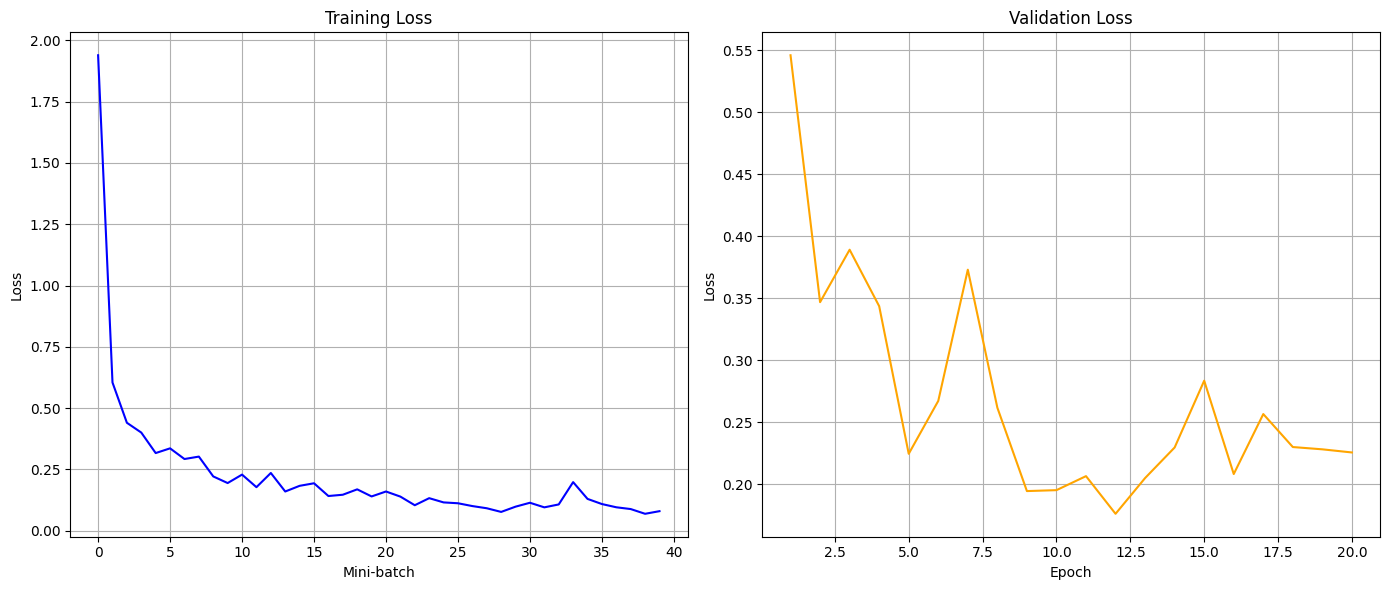

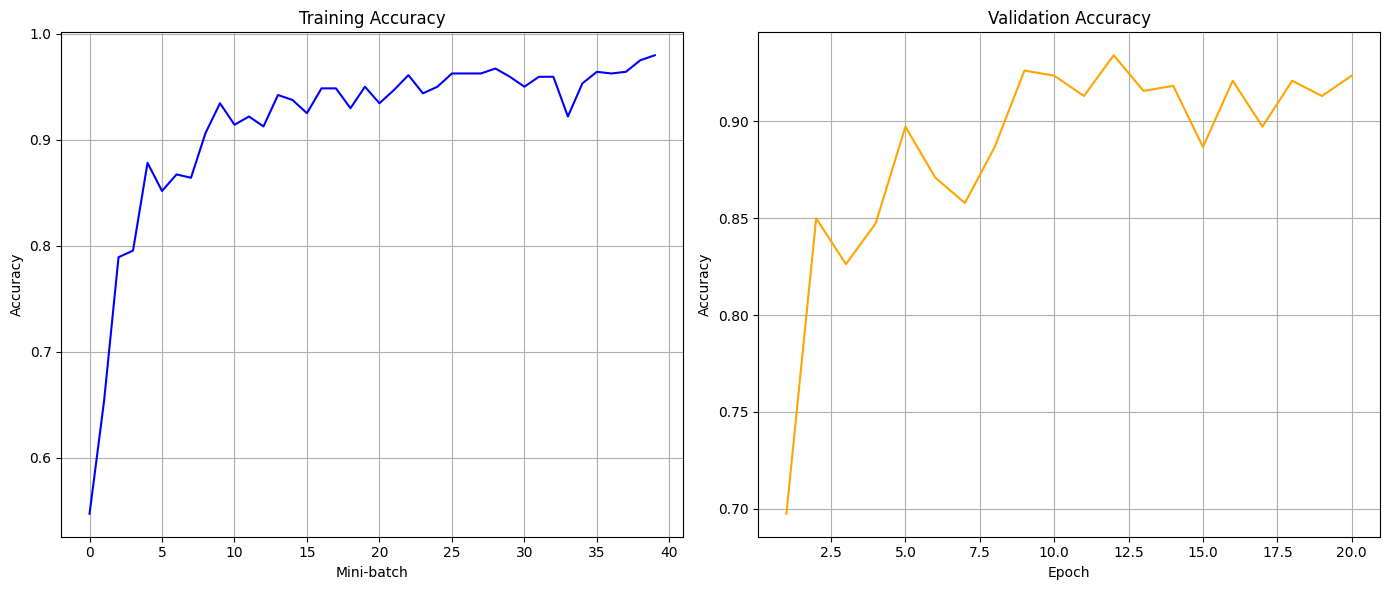

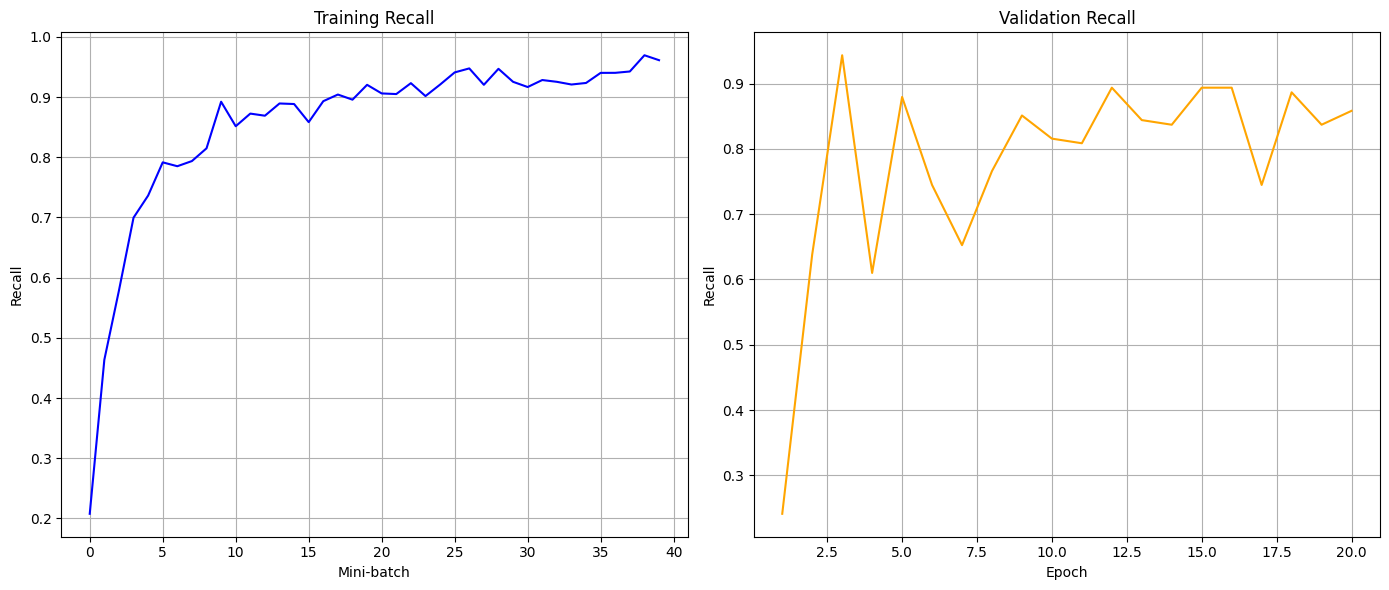

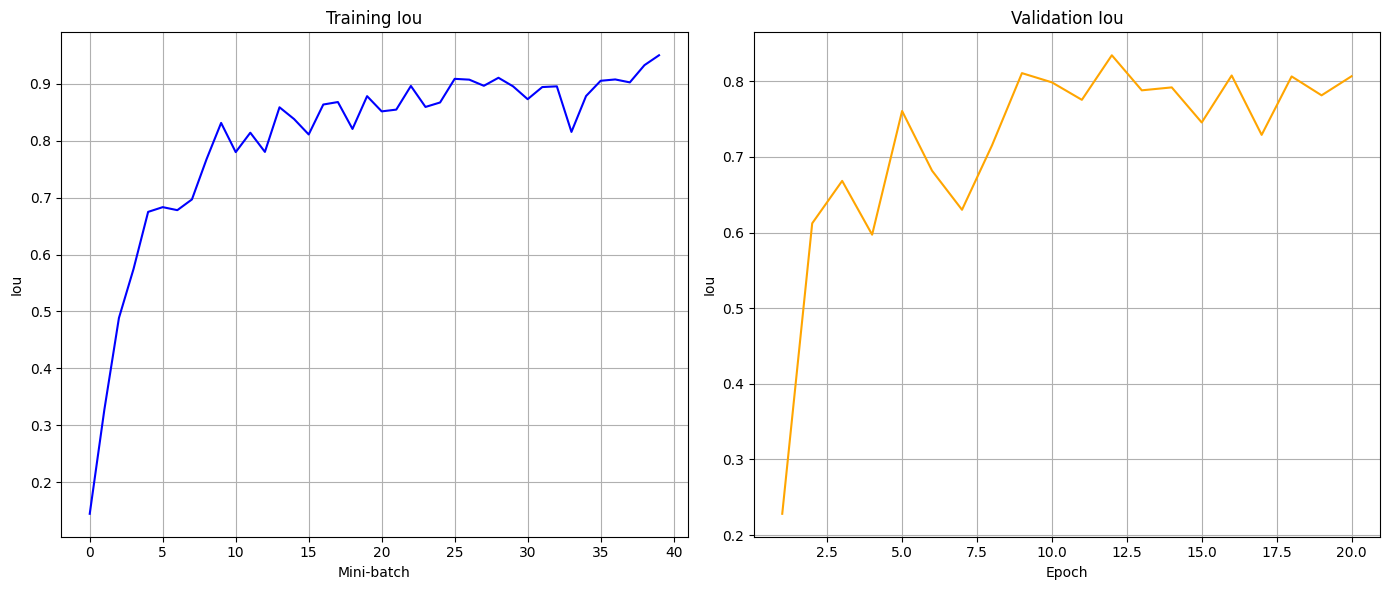

In [13]:
def plot_separate_metrics(train_metrics, val_metrics, metric_name):
    # Set up a larger plot
    plt.figure(figsize=(14, 6))

    # Subplot 1 for Training Metrics
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    train_values = [m[metric_name] for m in train_metrics]
    steps_train = list(range(len(train_values)))  # Assuming continuous recording
    plt.plot(steps_train, train_values, label='Train', color='blue')
    plt.xlabel('Mini-batch')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Training {metric_name.capitalize()}')
    plt.grid(True)

    # Subplot 2 for Validation Metrics
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    val_values = [m[metric_name] for m in val_metrics]
    epochs_val = list(range(1, len(val_values) + 1))  # Assuming recording per epoch
    plt.plot(epochs_val, val_values, label='Validation', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Validation {metric_name.capitalize()}')
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()

# Load validation metrics
with open(f'{MODEL_DIR}/val_metrics.json', 'r') as f:
    val_metrics = json.load(f)

# Load training metrics
with open(f'{MODEL_DIR}/training_metrics.json', 'r') as f:
    train_metrics = json.load(f)

plot_separate_metrics(train_metrics, val_metrics, 'loss')
plot_separate_metrics(train_metrics, val_metrics, 'accuracy')
plot_separate_metrics(train_metrics, val_metrics, 'recall')
plot_separate_metrics(train_metrics, val_metrics, 'iou')

In [15]:
model = torch.load(f'{MODEL_DIR}/best_model_epoch_12.pth').to(device)

with torch.no_grad():
    model.eval()
    test_TP = 0
    test_FP = 0
    test_FN = 0
    test_TN = 0

    loop = tqdm(test_dataloader, leave=True)
    k = 0
    for i, (images, spectrograms, labels) in enumerate(loop):     
        image_0 = images[0].to(device)
        image_1 = images[1].to(device)
        image_2 = images[2].to(device)
        image_3 = images[3].to(device)
        image_4 = images[4].to(device)

        spec_0 = spectrograms[0].to(device)
        spec_1 = spectrograms[1].to(device)
        spec_2 = spectrograms[2].to(device)
        spec_3 = spectrograms[3].to(device)
        spec_4 = spectrograms[4].to(device)
        spec_5 = spectrograms[5].to(device)
        spec_6 = spectrograms[6].to(device)

        # Forward pass
        outputs = model(
            image_0, image_1, image_2, image_3, image_4,
            spec_0, spec_1, spec_2, spec_3, spec_4, spec_5, spec_6
        )

        outputs = nn.functional.softmax(outputs, dim=1)

        outputs = outputs.cpu()

        # Convert labels and predictions to boolean values if they're not already
        labels_bool = labels.bool()
        outputs, predicted_classes = torch.max(outputs, 1)

        test_TP += ((predicted_classes == 1) & (labels_bool == 1)).sum().item()
        test_FP += ((predicted_classes == 1) & (labels_bool == 0)).sum().item()
        test_FN += ((predicted_classes == 0) & (labels_bool == 1)).sum().item()
        test_TN += ((predicted_classes == 0) & (labels_bool == 0)).sum().item()
    
    accuracy = (test_TP + test_TN) / (test_TP + test_FP + test_FN + test_TN)
    recall = test_TP / (test_TP + test_FN) if (test_TP + test_FN) > 0 else 0
    iou = test_TP / (test_TP + test_FP + test_FN) if (test_TP + test_FP + test_FN) > 0 else 0

    metric = {
        "accuracy": accuracy,
        "recall": recall,
        "iou": iou,
        "TP": test_TP,
        "FP": test_FP,
        "TN": test_TN,
        "FN": test_FN,
    }

    with open(f'{MODEL_DIR}/test_metrics.json', 'w') as f:
        json.dump(metric, f, indent=4)

    print(f"[Test Results] Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}")
print("Test finished")

100%|██████████| 4/4 [00:18<00:00,  4.67s/it]

[Test Results] Accuracy: 0.9242, Recall: 0.9079, IoU: 0.8118
Test finished
